### This notebook helps to visualize closed and open set performence of trained ML models

In [1]:
import re
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import NegativeClassOptimization.config as config
import glob
from pathlib import Path
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, log_loss
import seaborn as sns

In [385]:
### Creating true, pred dict
antigens = ['3VRL', '1NSN', '3RAJ', '5E94', '1H0D', '1WEJ', '1ADQ', '1FBI','2YPV', '1OB1']  

def antigens_from_path(folder_name):
    """Find antigens name in the file name, where every word separated with'_'. Antigen list is a global variable."""
    name_parts = folder_name.split('_')
    ags = [name_part for name_part in name_parts if name_part in antigens]
    return ags

def get_true_pred_paths_dict(pred_root_folder, pred_subfolder_regex, true_data_folder_path, true_file_pattern_format):
    """
    Creates a dictionary of a ML models and their corresponding test datasets depending on antigen(s) used for training.
    Antigen labeled as positive should be the same in training and testing datasets.
    
    Arguments:
        pred_root_folder: foler where models located
        pred_subfolder_regex: regular expresion to target trained models folders
        true_data_folder_path: folder where test datasets are located
        true_file_pattern_format: (str) string pattern for test data file formated using .format. Ex: "'/*{0}*_test*'.format(conf_ag[0])", 
                                                                                                          where conf_ag denotes list of antigens from the name of the model.
    """
    pred_paths = glob.glob(str(Path(config.IMMUNE_ML_BASE_PATH / pred_root_folder)) + pred_subfolder_regex) #might fail here
    pred_true_paths_dict = dict()
    for pred_path in pred_paths:
        #getting dataset file pattern in a bit tricky way
        pred_ag = antigens_from_path(pred_path.split('/')[-1])
        true_file_pattern = []
        exec('true_file_pattern.append(%s)' % true_file_pattern_format)
        true_file_pattern = true_file_pattern[0]
        
        #creating config path dict
        pred_path = Path(pred_path) / 'predictions.csv'
        pred_path = str(pred_path)
        true_path= glob.glob(str(Path(config.DATA_BASE_PATH / f'{true_data_folder_path}/')) + true_file_pattern)
        pred_ag = '_'.join(pred_ag)  # to put into a set together with another string
        pred_true_paths_dict[(pred_path, pred_ag)] = true_path
    return pred_true_paths_dict



In [98]:
pw_high_vs_low_knn_TF_paths = get_true_pred_paths_dict(pred_root_folder='pw_high_vs_low_knn_test', pred_subfolder_regex = '/pw*instruction', true_data_folder_path = 'full_data/high_low_concat/metadata', true_file_pattern_format = "'/*{0}*_test*'.format(pred_ag[0])")
pw_high_vs_low_svm_TF_paths = get_true_pred_paths_dict(pred_root_folder='pw_high_vs_low_svm_test', pred_subfolder_regex = '/pw*instruction', true_data_folder_path = 'full_data/high_low_concat/metadata', true_file_pattern_format = "'/*{0}*_test*'.format(pred_ag[0])")
pw_high_vs_low_rf_TF_paths = get_true_pred_paths_dict(pred_root_folder='pw_high_vs_low_rf_test', pred_subfolder_regex = '/pw*instruction', true_data_folder_path = 'full_data/high_low_concat/metadata', true_file_pattern_format = "'/*{0}*_test*'.format(pred_ag[0])")

In [99]:
# paths one_all_vs_high_low
one_all_vs_high_low_knn_TF_paths = get_true_pred_paths_dict(pred_root_folder='1all_vs_high-low_knn_test', pred_subfolder_regex = '/1*instruction', true_data_folder_path = 'full_data/high_low_concat/metadata', true_file_pattern_format = "'/*{0}*_test*'.format(pred_ag[0])")
one_all_vs_high_low_svm_TF_paths = get_true_pred_paths_dict(pred_root_folder='1all_vs_high-low_svm_test', pred_subfolder_regex = '/1*instruction', true_data_folder_path = 'full_data/high_low_concat/metadata', true_file_pattern_format = "'/*{0}*_test*'.format(pred_ag[0])")
one_all_vs_high_low_rf_TF_paths = get_true_pred_paths_dict(pred_root_folder='1all_vs_high-low_rf_test', pred_subfolder_regex = '/1*instruction', true_data_folder_path = 'full_data/high_low_concat/metadata', true_file_pattern_format = "'/*{0}*_test*'.format(pred_ag[0])")

In [106]:
# paths high_low_vs_high
high_low_vs_high_knn_TF_paths = get_true_pred_paths_dict(pred_root_folder='high_low_vs_high_knn_test', pred_subfolder_regex = '/high_low*instruction', true_data_folder_path = 'full_data/high_pairwise/metadata', true_file_pattern_format = "'/*{0}_{1}*_test*'.format(pred_ag[1],pred_ag[2])")
high_low_vs_high_svm_TF_paths = get_true_pred_paths_dict(pred_root_folder='high_low_vs_high_svm_test', pred_subfolder_regex = '/high_low*instruction', true_data_folder_path = 'full_data/high_pairwise/metadata', true_file_pattern_format = "'/*{0}_{1}*_test*'.format(pred_ag[1],pred_ag[2])")
high_low_vs_high_rf_TF_paths = get_true_pred_paths_dict(pred_root_folder='high_low_vs_high_rf_test', pred_subfolder_regex = '/high_low*instruction', true_data_folder_path = 'full_data/high_pairwise/metadata', true_file_pattern_format = "'/*{0}_{1}*_test*'.format(pred_ag[1],pred_ag[2])")

In [252]:
def calculate_metrics(y_true, y_pred):
    """
    Function calculates ML performance metrics.
    """
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    f1_micro = f1_score(y_true, y_pred,  average='micro')
    f1_macro = f1_score(y_true, y_pred,  average='macro')
    f1_weighted = f1_score(y_true, y_pred,  average='weighted')
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    log_loss_calc = log_loss(y_true, y_pred)
    return [accuracy,  balanced_accuracy, auc, f1_micro, f1_macro, f1_weighted, precision, recall, log_loss_calc] 

def get_metric(true_pred_paths_dict, ag_column_names_list, reverse_true=False):
    """
    Function that returns dataframe of calculated ML performance metrics. The dataframe's first columns will 
    contain antigens from a model and test dataset names. Antigen related column names should be given to a function as an argument.
    Arguments:
        true_pred_paths_dict: dictionary of predisted and true 
        ag_column_names_list: antigens column names to be used in dataframe
        reverse_true: boolen, default is False. If true 'binder' value in true dataset will be reversed.
    """
    res_list = []
    for pred_path_ag, true_path in  true_pred_paths_dict.items():
        ags = pred_path_ag[1].split('_')
        pred_path = pred_path_ag[0]
        true_path = true_path[0]
        df_pred = pd.read_csv(pred_path)
        df_true = pd.read_csv(true_path, sep = None, engine = 'python')
        df_pred.rename(columns={"binder":"binder_predicted"}, inplace=True)
        df_pred = df_pred[['example_id', 'binder_predicted']]
        df_true = df_true[['example_id', 'binder']]
        if reverse_true:
            if ags[0] == ags[2]: #is is unique or not
                df_true['binder'] = df_true['binder'] == False
        df_joined = df_true.join(df_pred, how = 'inner', lsuffix='_')
        metrics = calculate_metrics(df_joined['binder'], df_joined['binder_predicted'])
        res_list.append(ags + metrics) #here antigens number can be different
        #print('one folder finished')
    df_metrics = pd.DataFrame(res_list, columns = ag_column_names_list + ['accuracy_open_set',  'balanced_accuracy_open_set', 'auc_open_set', 'f1_micro_open_set',\
                                                      'f1_macro_open_set', 'f1_weighted_open_set', 'precision_open_set', 'recall_open_set', 'log_loss_open_set']) #this mighr be diffreent
    return df_metrics


In [146]:
df_os_high_low_vs_high_knn = get_metric(high_low_vs_high_knn_TF_paths, ['ag_tr', 'ag_ts1', 'ag_ts2'], reverse_true=True)
df_os_high_low_vs_high_svm = get_metric(high_low_vs_high_svm_TF_paths, ['ag_tr', 'ag_ts1', 'ag_ts2'], reverse_true=True)
df_os_high_low_vs_high_rf = get_metric(high_low_vs_high_rf_TF_paths, ['ag_tr', 'ag_ts1', 'ag_ts2'], reverse_true=True)

In [202]:
df_os_one_all_vs_high_low_knn = get_metric(one_all_vs_high_low_knn_TF_paths, ['ag_tr', 'ag_ts'])
df_os_one_all_vs_high_low_svm = get_metric(one_all_vs_high_low_svm_TF_paths, ['ag_tr', 'ag_ts'])
df_os_one_all_vs_high_low_rf = get_metric(one_all_vs_high_low_rf_TF_paths, ['ag_tr', 'ag_ts'])

In [116]:
df_os_pw_high_vs_low_knn = get_metric(pw_high_vs_low_knn_TF_paths, ['ag_tr1', 'ag_tr2', 'ag_ts1'])
df_os_pw_high_vs_low_svm = get_metric(pw_high_vs_low_svm_TF_paths, ['ag_tr1', 'ag_tr2', 'ag_ts1'])
df_os_pw_high_vs_low_rf = get_metric(pw_high_vs_low_rf_TF_paths, ['ag_tr1', 'ag_tr2', 'ag_ts1'])

In [120]:
def merge_performance_files(res_folder, regex_subfolder_name, performance_file_name):
    """
    Merges immuneML result csv files to one DataFrame.
    Arguments:
        res_folder: foler where models located
        regex_subfolder_name: regular expresion to target trained models folders
        performance_file_name: self explanatory, ususally 'binder_optimal_models_performance.csv'
    """
    BASE_PATH = config.IMMUNE_ML_BASE_PATH/ f"{res_folder}"
    paths = list(Path(BASE_PATH).glob(regex_subfolder_name))
    dfs = []
    for res in paths:
        df_i = pd.read_csv(res / performance_file_name)
        assert df_i.shape[0] == 1
        ags = antigens_from_path(res.name)
        df_i["ags"] = '_'.join(ags)
        dfs.append(df_i)
    df_merged = pd.concat(dfs, axis=0)
    return df_merged

In [121]:
df_cs_rf_high_low = merge_performance_files('high_low_rf_out', 'fit_*_wo_dupl_instruction', 'binder_optimal_models_performance.csv')
df_cs_svm_high_low= merge_performance_files('high_low_svm_out', 'fit_*_wo_dupl_instruction', 'binder_optimal_models_performance.csv')
df_cs_knn_high_low = merge_performance_files('high_low_knn_out', 'fit_*_wo_dupl_instruction', 'binder_optimal_models_performance.csv')

In [125]:
df_cs_rf_pw_high= merge_performance_files('pw_high_rf_out', 'fit_*_wo_dupl_instruction', 'binder_optimal_models_performance.csv')
df_cs_svm_pw_high = merge_performance_files('pw_high_svm_out', 'fit_*_wo_dupl_instruction', 'binder_optimal_models_performance.csv')
df_cs_knn_pw_high = merge_performance_files('pw_high_knn_out', 'fit_*_wo_dupl_instruction', 'binder_optimal_models_performance.csv')

In [128]:
df_cs_rf_1vsall = merge_performance_files('1_vs_all_rf_out', 'fit_*_vs_all_instruction', 'binder_optimal_models_performance.csv')
df_cs_svm_1vsall = merge_performance_files('1_vs_all_svm_out', 'fit_*_vs_all_instruction', 'binder_optimal_models_performance.csv')
df_cs_knn_1vsall =  merge_performance_files('1_vs_all_knn_out', 'fit_*_vs_all_instruction', 'binder_optimal_models_performance.csv')

In [141]:
def violin_w_threshold(df_os, df_cs, metric, ag_os_col, ag_cs_col):
    """
    Function plots distribution of open set performance and straight line designate closed set performance. So far can be used to compare
    performace of models trained on high_low data (closed set) and tested on pw_high (open set).
    Arguments:
        df_os: DataFrame of open set performace 
        df_cs: DataFrame of closed set performace
        metric: metrics list to plot
        ag_os_col: name of a column containing antigen name in df_os
        ag_cs_col: name of a column containing antigen name in df_cs
        
    """
    ordered = df_os.groupby(ag_os_col).mean().sort_values(metric+'_open_set').index
    v_plot = sns.violinplot(data = df_os[[ ag_os_col,metric+'_open_set']], x=  ag_os_col, y = metric+'_open_set', color = '#6e9ad2',   order = ordered, cut = 0)
    df_cs_sorted = df_cs.set_index(ag_cs_col).loc[ordered].reset_index()
    for ind, row in df_cs_sorted.iterrows():
        plt.hlines(row[metric],xmin=ind-0.5,xmax=ind+0.5,colors="#f99c00");    

In [142]:
df_os_high_low_vs_high_rf.head()

,ag_tr,ag_ts1,ag_ts2,accuracy_open_set,balanced_accuracy_open_set,auc_open_set,f1_micro_open_set,f1_macro_open_set,f1_weighted_open_set,precision_open_set,recall_open_set,log_loss_open_set
0,3VRL,3VRL,1WEJ,0.192177,0.192177,0.192177,0.192177,0.161198,0.161198,0.277641,0.384354,27.901622
1,3RAJ,1NSN,3RAJ,0.145238,0.145238,0.145238,0.145238,0.126819,0.126819,0.225092,0.290476,29.522830
2,1ADQ,1ADQ,2YPV,0.228435,0.228435,0.228435,0.228435,0.185956,0.185956,0.313597,0.456871,26.649298
3,3RAJ,3RAJ,1H0D,0.194082,0.194082,0.194082,0.194082,0.162536,0.162536,0.279624,0.388163,27.835834
4,1WEJ,1WEJ,1ADQ,0.123537,0.123537,0.123537,0.123537,0.109954,0.109954,0.198123,0.247075,30.272345


In [132]:
df_cs_rf_high_low.head()

,hp_setting,split,precision,f1_macro,f1_micro,accuracy,confusion_matrix,balanced_accuracy,f1_weighted,auc,recall,log_loss,ags
0,onehot_encoding_randomforest_default_model,1,0.955651,0.945912,0.945918,0.945918,not computed,0.945918,0.945912,0.013905,0.935238,3.993237,2YPV
0,onehot_encoding_randomforest_default_model,1,0.960976,0.949993,0.950000,0.950000,not computed,0.950000,0.949993,0.010306,0.938095,3.414095,1NSN
0,onehot_encoding_randomforest_default_model,1,0.976031,0.953921,0.953946,0.953946,not computed,0.953946,0.953921,0.009054,0.930748,2.809082,1OB1
0,onehot_encoding_randomforest_default_model,1,0.972640,0.948879,0.948912,0.948912,not computed,0.948912,0.948879,0.011679,0.923810,2.408636,3RAJ
0,onehot_encoding_randomforest_default_model,1,0.966588,0.955981,0.955986,0.955986,not computed,0.955986,0.955981,0.009388,0.944626,3.575560,1WEJ


In [137]:
metrics_list = ['balanced_accuracy',  'accuracy',  'f1_micro', 'f1_macro', 'recall', 'precision']

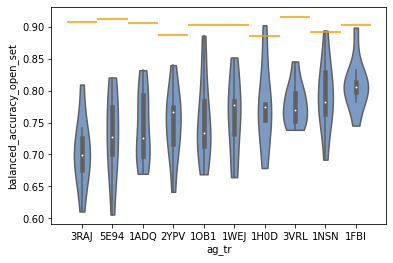

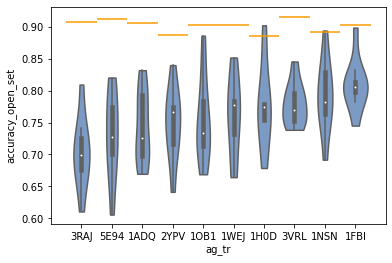

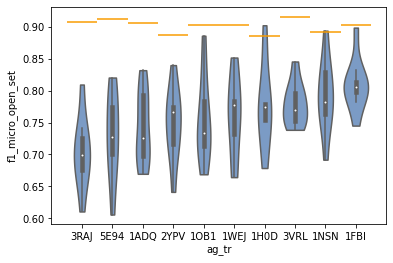

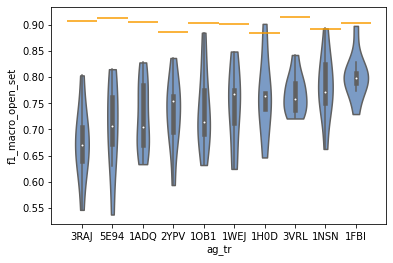

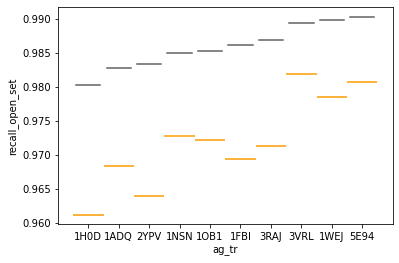

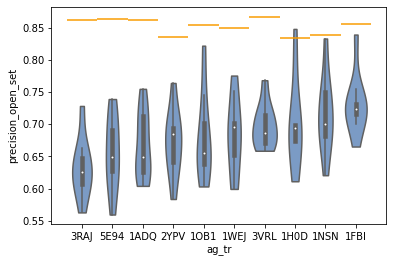

In [149]:
for metric in metrics_list:
    violin_w_threshold(df_os_high_low_vs_high_knn, df_cs_knn_high_low, metric, 'ag_tr', 'ags')
    plt.show()

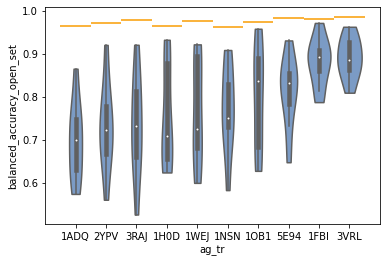

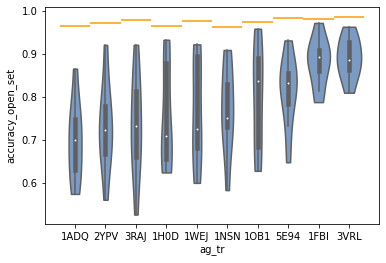

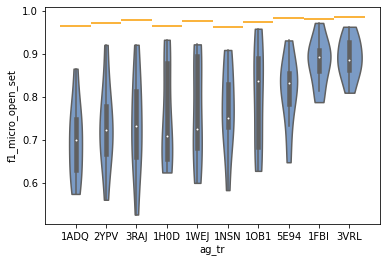

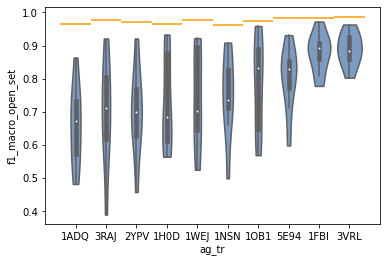

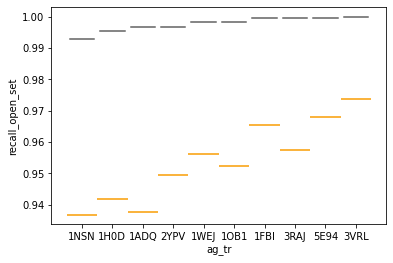

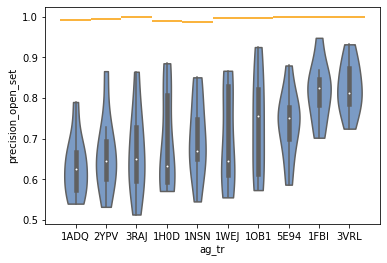

In [150]:
for metric in metrics_list:
    violin_w_threshold(df_os_high_low_vs_high_svm, df_cs_svm_high_low, metric, 'ag_tr', 'ags')
    plt.show()

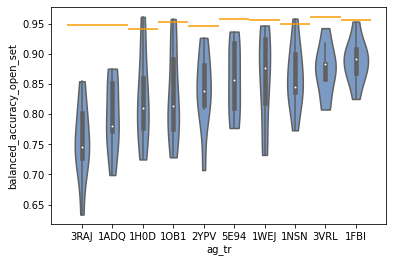

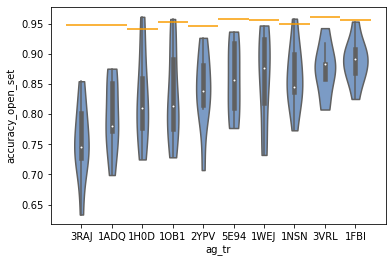

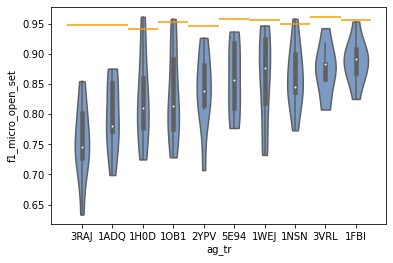

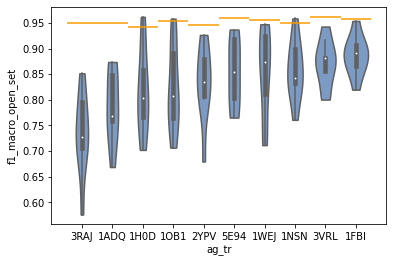

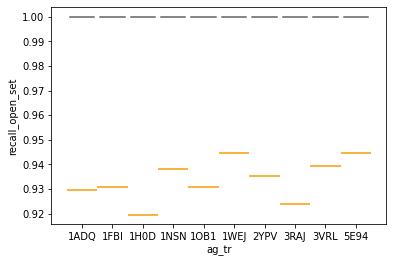

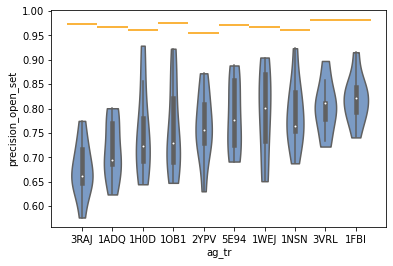

In [148]:
for metric in metrics_list:
    violin_w_threshold(df_os_high_low_vs_high_rf, df_cs_rf_high_low, metric, 'ag_tr', 'ags')
    plt.show()

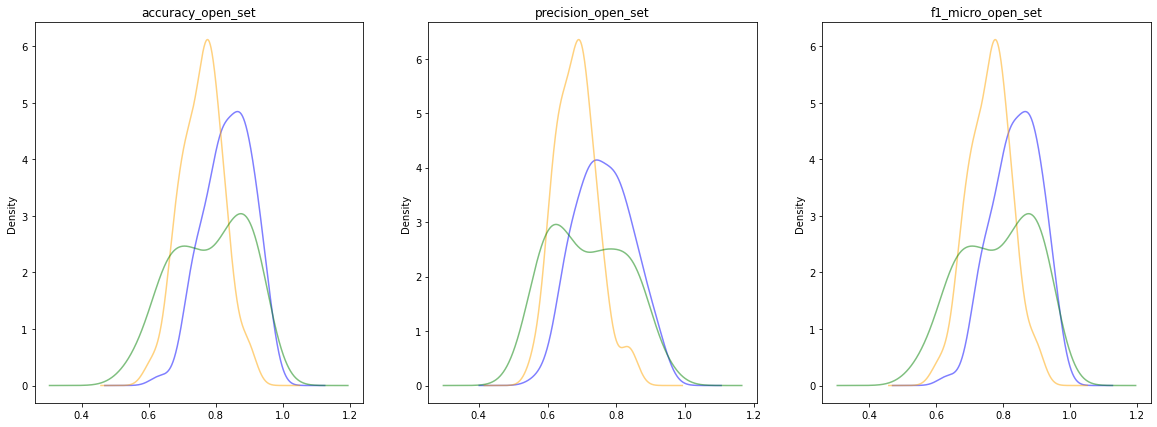

In [155]:
fig, axes = plt.subplots(1,3, figsize=(20,7))
metrics_mini = ['accuracy_open_set', 'precision_open_set', 'f1_micro_open_set']
df_os_high_low_vs_high_rf[metrics_mini].plot(kind='kde', subplots=True, ax=axes, alpha=0.5,  color='b', title = metrics_mini, legend=False)
df_os_high_low_vs_high_knn[metrics_mini].plot(kind='kde', subplots=True, ax=axes, alpha=0.5,  color='orange', title = metrics_mini, legend=False)
df_os_high_low_vs_high_svm[metrics_mini].plot(kind='kde', subplots=True, ax=axes, alpha=0.5,  color='green', title = metrics_mini, legend=False);

In [183]:
def pw_high_join_ag(df):
    df['ags_tr'] = df['ag_tr1']+ '_' +df['ag_tr2']

In [184]:
pw_high_join_ag(df_os_pw_high_vs_low_knn)
pw_high_join_ag(df_os_pw_high_vs_low_rf)
pw_high_join_ag(df_os_pw_high_vs_low_svm)

In [173]:
#splitting ags column to separate pos. and neg. ag
#pw_high_split_ag(df_cs_knn_pw_high)
#pw_high_split_ag(df_cs_svm_pw_high)
#pw_high_split_ag(df_cs_rf_pw_high)

In [190]:
def parallel_coordinates_plot(df_cs, df_os, metric, ag_os_col, ag_cs_col):
    """
    Function plots change in performance between closed set and open set.
    Arguments:
        df_os: DataFrame of open set performace 
        df_cs: DataFrame of closed set performace
        metric: metrics list to plot
        ag_os_col: name of a column containing antigen name in df_os
        ag_cs_col: name of a column containing antigen name in df_cs
    """
    df_merged = df_os.merge(df_cs, right_on=ag_os_col, left_on=ag_cs_col)
    df_plotting = df_merged[[ag_os_col, f'{metric}', f'{metric}_open_set']]
    fig, ax = plt.subplots()
    pd.plotting.parallel_coordinates(df_plotting, class_column=ag_os_col, ax=ax)
    ax.get_legend().remove()

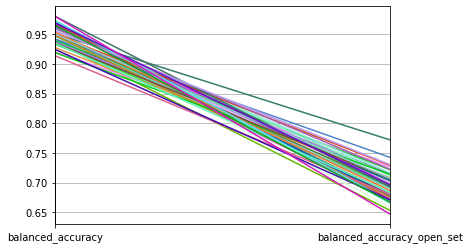

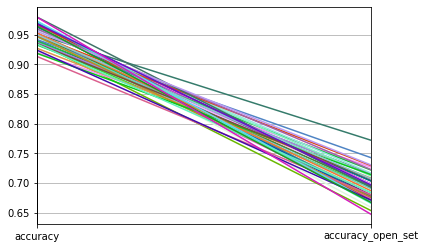

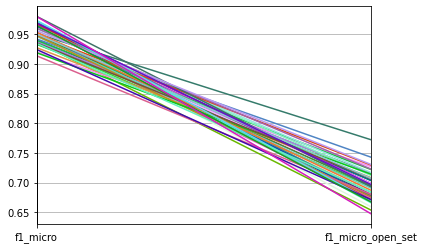

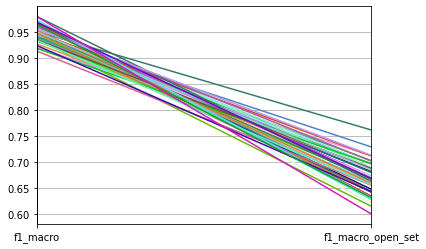

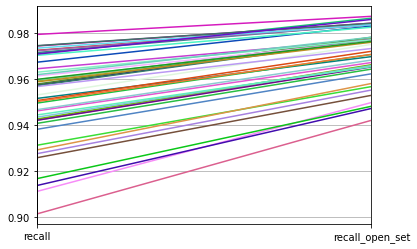

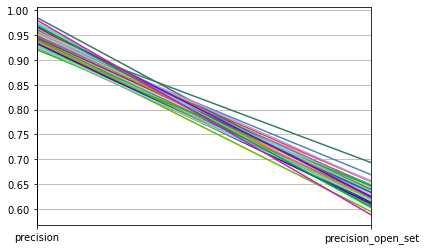

In [191]:
for metric in metrics_list:
    parallel_coordinates_plot(df_os_pw_high_vs_low_knn , df_cs_knn_pw_high, metric, 'ags_tr', 'ags')
    plt.savefig(f'./plots/pw_high_vs_low_knn_{metric}.png')
    plt.show()

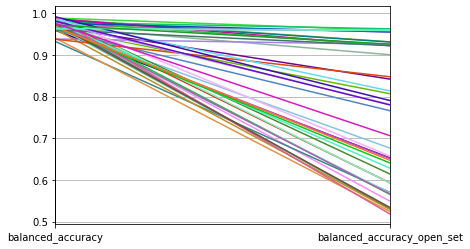

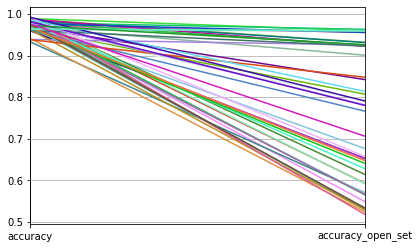

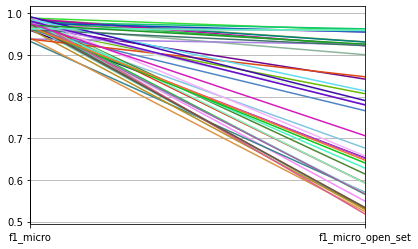

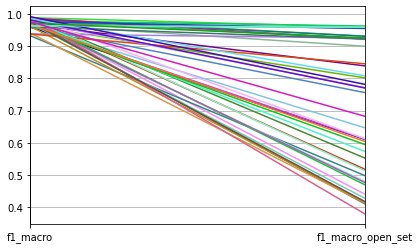

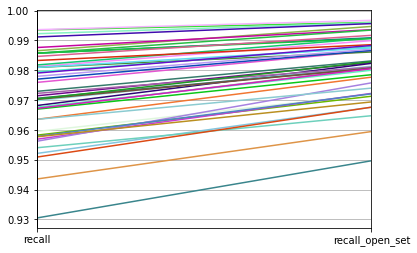

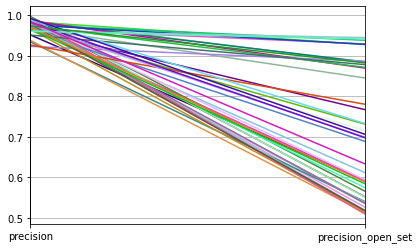

In [192]:
for metric in metrics_list:
    parallel_coordinates_plot(df_os_pw_high_vs_low_svm , df_cs_svm_pw_high, metric, 'ags_tr', 'ags')
    plt.savefig(f'./plots/pw_high_vs_low_knn_{metric}.png')
    plt.show()

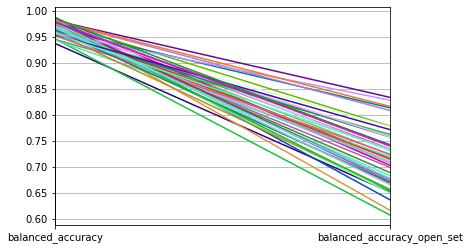

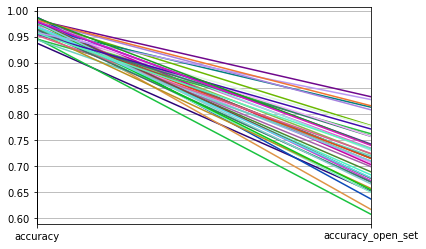

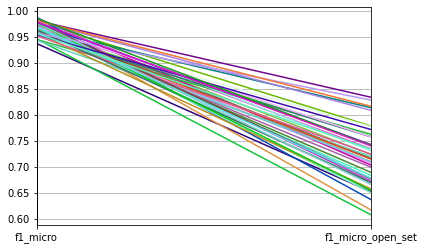

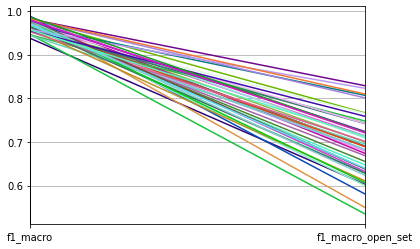

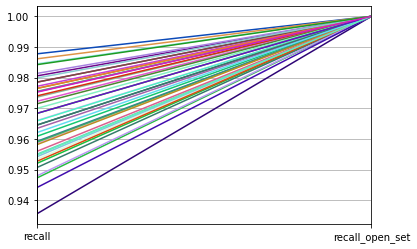

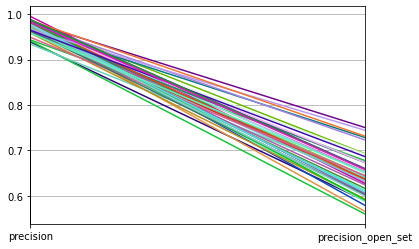

In [193]:
for metric in metrics_list:
    parallel_coordinates_plot(df_os_pw_high_vs_low_rf , df_cs_rf_pw_high, metric, 'ags_tr', 'ags')
    plt.savefig(f'./plots/pw_high_vs_low_knn_{metric}.png')
    plt.show()

## 1_vs_all test

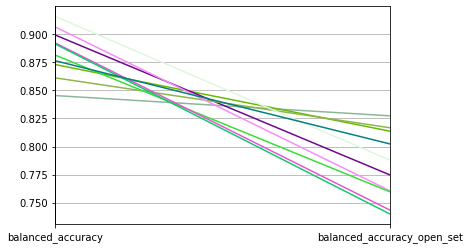

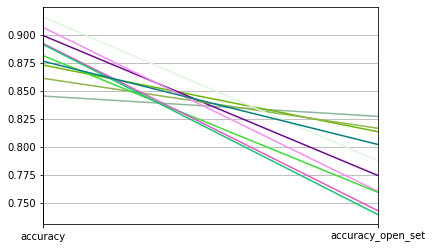

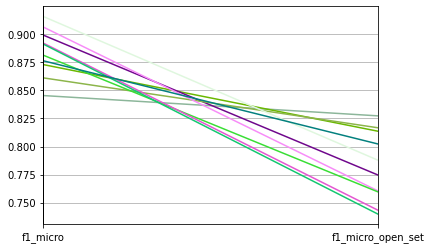

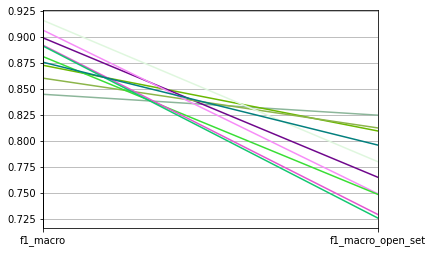

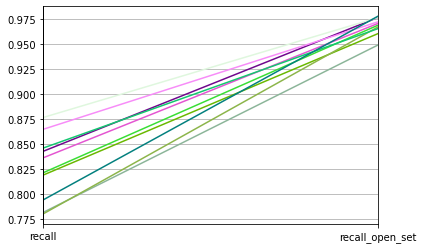

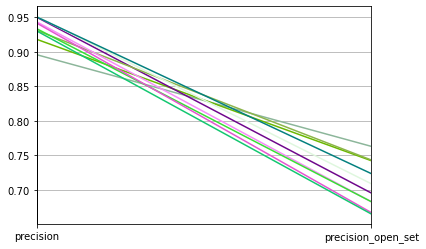

In [197]:
for metric in metrics_list:    
    parallel_coordinates_plot(df_os_one_all_vs_high_low_knn , df_cs_knn_1vsall, metric, 'ag_tr','ags')
    plt.show()

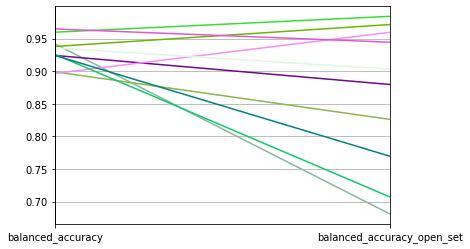

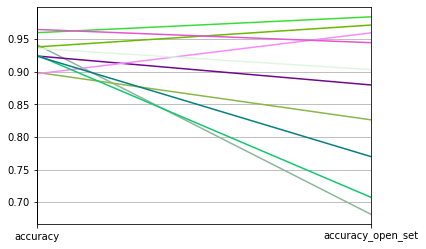

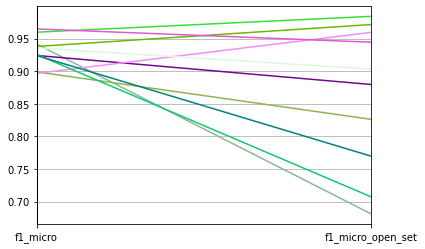

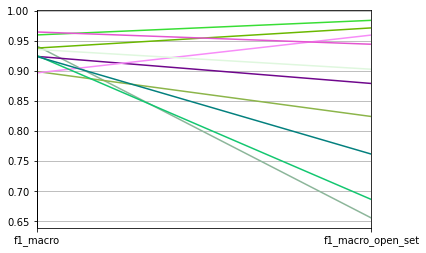

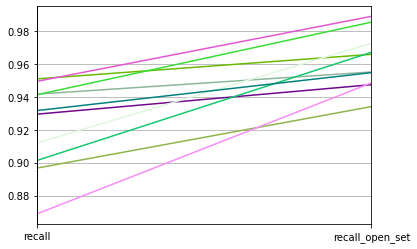

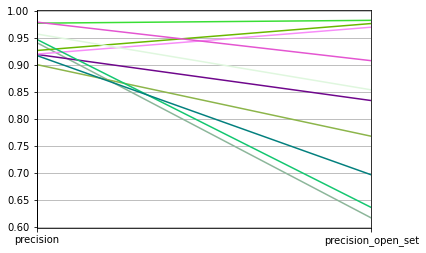

In [204]:
for metric in metrics_list:    
    parallel_coordinates_plot(df_os_one_all_vs_high_low_svm , df_cs_svm_1vsall, metric, 'ag_tr','ags')
    plt.show()

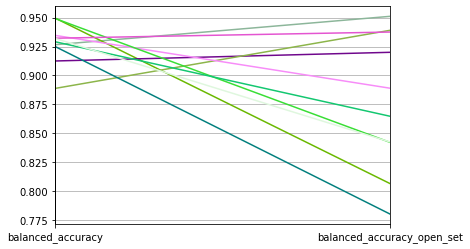

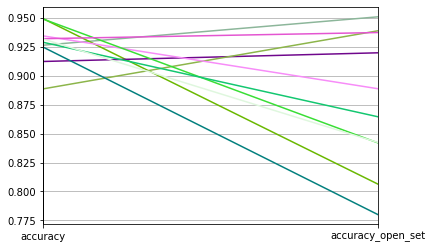

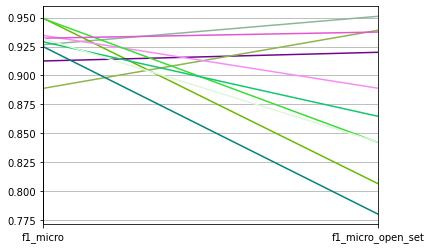

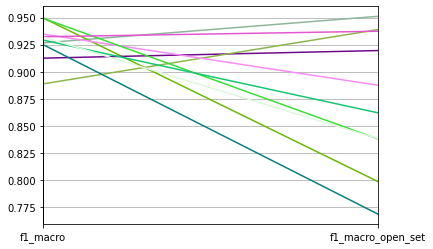

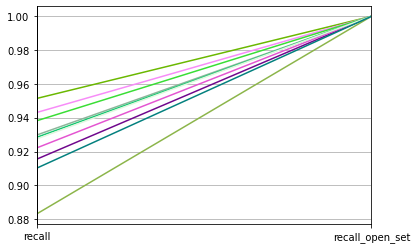

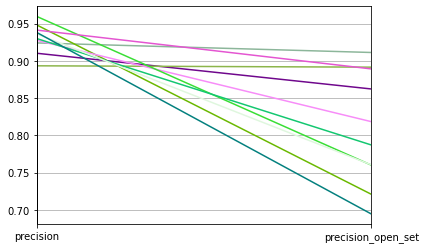

In [199]:
for metric in metrics_list:    
    parallel_coordinates_plot(df_os_one_all_vs_high_low_rf , df_cs_rf_1vsall, metric, 'ag_tr','ags')
    plt.savefig(f'./plots/1vsall_vs_low_knn_{metric}.png')
    plt.show()

In [302]:
pw_high_cross_knn_TF_paths = get_true_pred_paths_dict(pred_root_folder ='pw_high_cross_knn_test', pred_subfolder_regex ='/pw*instruction', true_data_folder_path = 'full_data/high_pairwise/test_tsv/cross_pw_high', true_file_pattern_format = "'/{0}*{1}_test*'.format(pred_ag[0], pred_ag[2])")
pw_high_cross_svm_TF_paths = get_true_pred_paths_dict(pred_root_folder ='pw_high_cross_svm_test', pred_subfolder_regex ='/pw*instruction', true_data_folder_path = 'full_data/high_pairwise/test_tsv/cross_pw_high', true_file_pattern_format = "'/{0}*{1}_test*'.format(pred_ag[0], pred_ag[2])")
pw_high_cross_rf_TF_paths = get_true_pred_paths_dict(pred_root_folder ='pw_high_cross_rf_test', pred_subfolder_regex ='/pw*instruction', true_data_folder_path = 'full_data/high_pairwise/test_tsv/cross_pw_high', true_file_pattern_format = "'/{0}*{1}_test*'.format(pred_ag[0], pred_ag[2])")

In [ ]:
df_os_pw_high_cross_knn = get_metric(pw_high_cross_knn_TF_paths, ['ag_tr1', 'ag_tr2', 'ag_cross'])
df_os_pw_high_cross_svm = get_metric(pw_high_cross_svm_TF_paths, ['ag_tr1', 'ag_tr2', 'ag_cross'])
df_os_pw_high_cross_rf = get_metric(pw_high_cross_rf_TF_paths, ['ag_tr1', 'ag_tr2', 'ag_cross'])

In [ ]:
def separate_cs_os(df):
    df['open_set'] = df['ag_tr2'] != df['ag_cross']
    return df

In [ ]:
df_os_pw_high_cross_knn = separate_cs_os(df_os_pw_high_cross_knn)
df_os_pw_high_cross_svm = separate_cs_os(df_os_pw_high_cross_svm)
df_os_pw_high_cross_rf = separate_cs_os(df_os_pw_high_cross_rf)

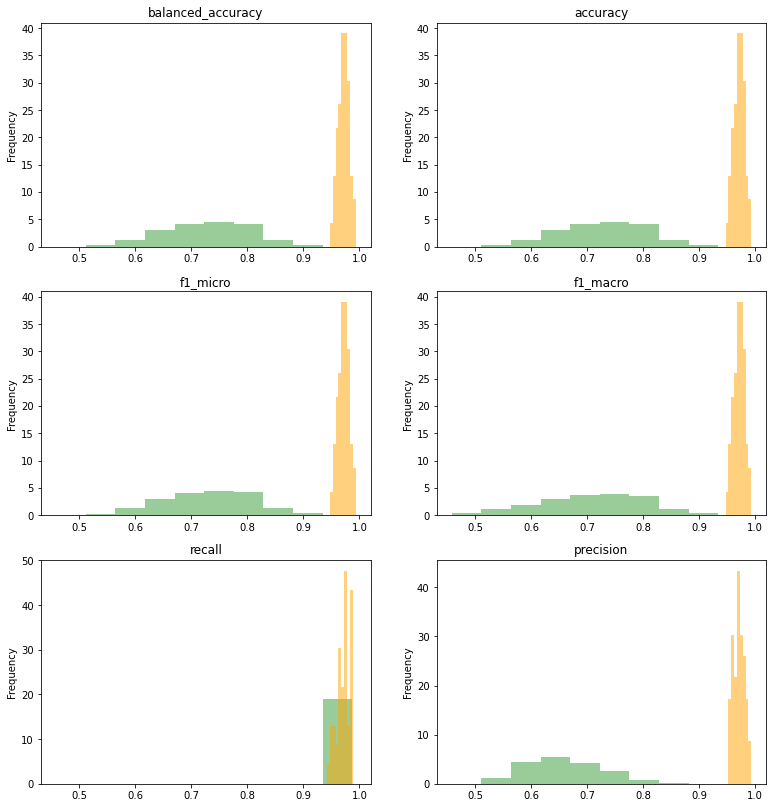

In [361]:
fig, axes = plt.subplots(3,2, figsize=(13,14))
df_os_pw_high_cross_knn[df_os_pw_high_cross_knn['open_set']==True][metrics_list_os].plot(kind='hist', density=True,  subplots=True, ax=axes,  color = 'green', alpha = 0.4, title = metrics_list, legend=False)
df_os_pw_high_cross_knn[df_os_pw_high_cross_knn['open_set']!=True][metrics_list_os].plot(kind='hist', density=True, subplots=True, ax=axes, color = 'orange', alpha = 0.5, title = metrics_list, legend=False);

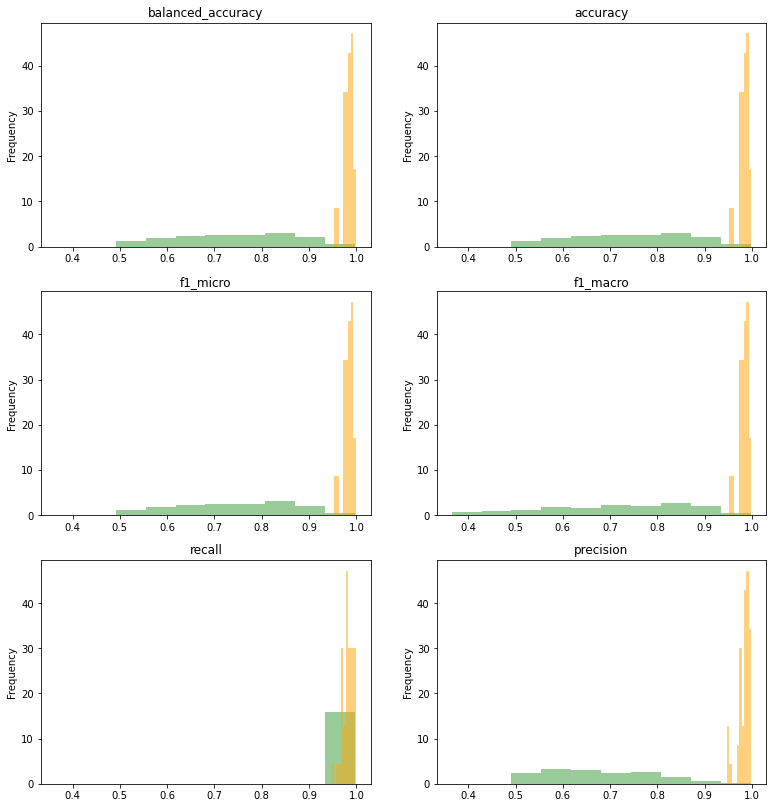

In [362]:
fig, axes = plt.subplots(3,2, figsize=(13,14))
df_os_pw_high_cross_svm[df_os_pw_high_cross_svm['open_set']==True][metrics_list_os].plot(kind='hist', density=True,  subplots=True, ax=axes,  color = 'green', alpha = 0.4, title = metrics_list, legend=False)
df_os_pw_high_cross_svm[df_os_pw_high_cross_svm['open_set']!=True][metrics_list_os].plot(kind='hist', density=True, subplots=True, ax=axes, color = 'orange', alpha = 0.5, title = metrics_list, legend=False);

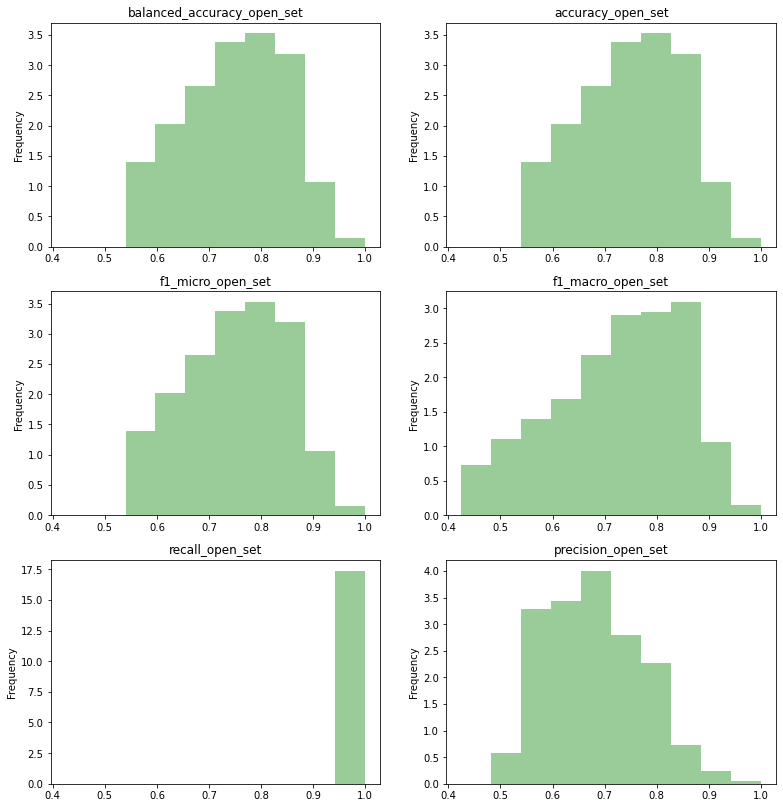

In [384]:
fig, axes = plt.subplots(3,2, figsize=(13,14))
df_os_pw_high_cross_rf[df_os_pw_high_cross_rf['open_set']==True][metrics_list_os].plot(kind='hist', density=True,  subplots=True, ax=axes,  color = 'green', alpha = 0.4, title = metrics_list_os, legend=False);
#df_os_pw_high_cross_rf[df_os_pw_high_cross_rf['open_set']!=True][metrics_list_os].plot(kind='hist', density=True, subplots=True, ax=axes, color = 'orange', alpha = 0.5, title = metrics_list_os, legend=False)